<h1>Palmprint identification<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Import-dependencies" data-toc-modified-id="Import-dependencies-1">Import dependencies</a></span></li><li><span><a href="#Load-data" data-toc-modified-id="Load-data-2">Load data</a></span></li><li><span><a href="#Preprocessing" data-toc-modified-id="Preprocessing-3">Preprocessing</a></span><ul class="toc-item"><li><span><a href="#Apply-a-Gaussian-filter-for-smoothing-followed-by-a-thresholding-to-binary" data-toc-modified-id="Apply-a-Gaussian-filter-for-smoothing-followed-by-a-thresholding-to-binary-3.1">Apply a Gaussian filter for smoothing followed by a thresholding to binary</a></span></li><li><span><a href="#Boundary-tracking-for-gaps-between-the-firgers-1-2-and-3-4" data-toc-modified-id="Boundary-tracking-for-gaps-between-the-firgers-1-2-and-3-4-3.2">Boundary tracking for gaps between the firgers 1-2 and 3-4</a></span><ul class="toc-item"><li><span><a href="#Identifying-palm's-contour-for-the-left-hand-side" data-toc-modified-id="Identifying-palm's-contour-for-the-left-hand-side-3.2.1">Identifying palm's contour for the left hand side</a></span></li><li><span><a href="#Identifying-fingers-extreme-points" data-toc-modified-id="Identifying-fingers-extreme-points-3.2.2">Identifying fingers extreme points</a></span></li><li><span><a href="#Identifying-the-extreme-points-from-the-boundaries" data-toc-modified-id="Identifying-the-extreme-points-from-the-boundaries-3.2.3">Identifying the extreme points from the boundaries</a></span></li></ul></li><li><span><a href="#Detecting-the-tangent-for-the-boundaries-between-fingers" data-toc-modified-id="Detecting-the-tangent-for-the-boundaries-between-fingers-3.3">Detecting the tangent for the boundaries between fingers</a></span><ul class="toc-item"><li><span><a href="#Verification" data-toc-modified-id="Verification-3.3.1">Verification</a></span></li></ul></li><li><span><a href="#Detecting-the-new-coordinates-system" data-toc-modified-id="Detecting-the-new-coordinates-system-3.4">Detecting the new coordinates system</a></span><ul class="toc-item"><li><span><a href="#Getting-the-perpendicular-on-tangent:-m1-*-m2-=--1" data-toc-modified-id="Getting-the-perpendicular-on-tangent:-m1-*-m2-=--1-3.4.1">Getting the perpendicular on tangent: m1 * m2 = -1</a></span></li></ul></li><li><span><a href="#Get-all-coordinates-inside-rectagle" data-toc-modified-id="Get-all-coordinates-inside-rectagle-3.5">Get all coordinates inside rectagle</a></span></li><li><span><a href="#Gather-everything-in-a-preprocessing-function" data-toc-modified-id="Gather-everything-in-a-preprocessing-function-3.6">Gather everything in a preprocessing function</a></span></li><li><span><a href="#Export-results-after-processing" data-toc-modified-id="Export-results-after-processing-3.7">Export results after processing</a></span></li></ul></li><li><span><a href="#Feature-Extraction-and-Coding" data-toc-modified-id="Feature-Extraction-and-Coding-4">Feature Extraction and Coding</a></span></li></ul></div>

![title](./palmprint.jpg)

## Import dependencies

In [1]:
import matplotlib.image as img
import matplotlib.pyplot as plt
import os
import warnings
import numpy as np
import cv2
import tqdm

warnings.filterwarnings("ignore")

## Load data

In [2]:
len(os.listdir('./imagini'))

300

In [3]:
all_files = os.listdir('./imagini')
all_files[:10]

['PolyU_386_F_08.bmp',
 'PolyU_384_S_02(1).bmp',
 'PolyU_386_S_09(1).bmp',
 'PolyU_381_S_04.bmp',
 'PolyU_380_S_10.bmp',
 'PolyU_380_S_04.bmp',
 'PolyU_381_S_10.bmp',
 'PolyU_383_F_02.bmp',
 'PolyU_382_F_02.bmp',
 'PolyU_379_S_02(1).bmp']

In [4]:
image = img.imread('./imagini/PolyU_381_S_10.bmp')
image.shape

(284, 384)

Shape:  (284, 384, 3)


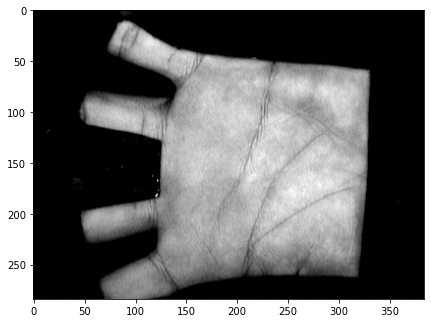

In [5]:
def see_test_image(filename):
    gray = cv2.imread(filename, 0)
    image = cv2.merge([gray, gray, gray])
    print('Shape: ', image.shape)

    fig = plt.figure(figsize=(7,7))
    plt.imshow(image)
    plt.show()

see_test_image('./imagini/PolyU_386_F_08.bmp')

In [6]:
def visualize_image(image, title=None):
    fig = plt.figure(figsize=(7,7))
    
    if len(list(image.shape)) == 2:
        image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
        
    plt.imshow(image)
    if title != None:
        plt.title(title, fontdict = {'fontsize' : 10})
    plt.show()

## Preprocessing

### Apply a Gaussian filter for smoothing followed by a thresholding to binary

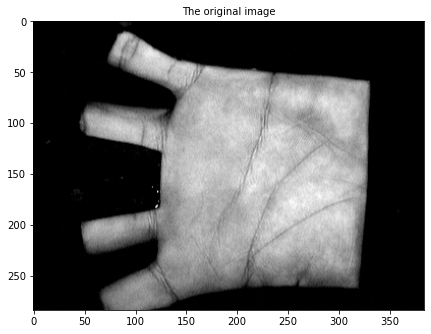

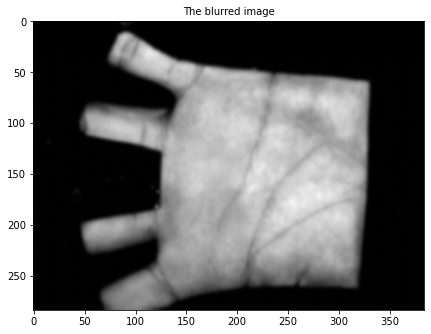

In [7]:
def gaussian_blur(original_img, filter_size):
    return cv2.GaussianBlur(original_img, filter_size, 0)

def visualize_original_blurred_in_comparison(filename, filter_size, blur_function):
    original_img = cv2.imread(filename)
    blur = blur_function(original_img, filter_size)
    visualize_image(original_img, title='The original image')
    visualize_image(blur, title='The blurred image')
    
visualize_original_blurred_in_comparison(
    filename='./imagini/PolyU_386_F_08.bmp', 
    filter_size=(7,7),
    blur_function=gaussian_blur)

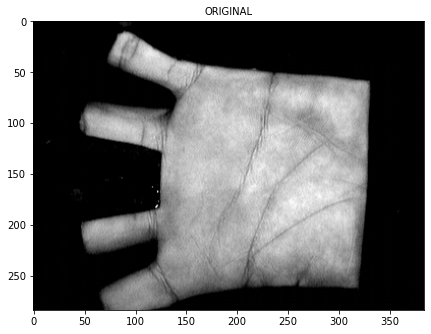

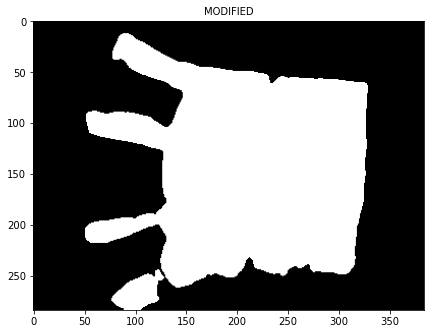

In [8]:
def visualize_original_vs_modified(original_img, modified):
    visualize_image(original_img, title='ORIGINAL')
    visualize_image(modified, title='MODIFIED')

def thresholding_to_binary(image):
    return cv2.threshold(image, 120, 255, cv2.THRESH_BINARY)[1] 

filter_size = (9,9)
original_img = cv2.imread('./imagini/PolyU_386_F_08.bmp', 0)
modified_img = gaussian_blur(original_img, filter_size)
modified_img = thresholding_to_binary(modified_img)
visualize_original_vs_modified(original_img, modified_img)

### Boundary tracking for gaps between the firgers 1-2 and 3-4

In [9]:
def get_starting_points_white(image):
    image = modified_img

    lines = image.shape[0]
    columns = image.shape[1]

    starting_points_white = []

    for i in range(lines):
        for j in range(columns):
            if image[i][j] == 0:
                continue
            else:
                starting_points_white.append((i, j))
                break

    sorted_coordinates_based_on_line_and_after_column = sorted(sorted(starting_points_white, key=lambda x: x[0]), 
                                                key=lambda x: x[1], reverse=True)
    return sorted_coordinates_based_on_line_and_after_column

In [10]:
sorted_coordinates_based_on_line_and_after_column = get_starting_points_white(image)

In [11]:
sorted_coordinates_based_on_line_and_after_column[:30]

[(70, 147),
 (71, 147),
 (72, 147),
 (73, 147),
 (74, 147),
 (75, 147),
 (68, 146),
 (69, 146),
 (76, 146),
 (77, 146),
 (78, 145),
 (79, 145),
 (67, 144),
 (80, 144),
 (81, 144),
 (82, 143),
 (83, 143),
 (84, 142),
 (85, 142),
 (66, 141),
 (86, 141),
 (87, 141),
 (65, 138),
 (64, 136),
 (63, 135),
 (62, 134),
 (61, 133),
 (60, 131),
 (174, 131),
 (175, 131)]

#### Identifying palm's contour for the left hand side

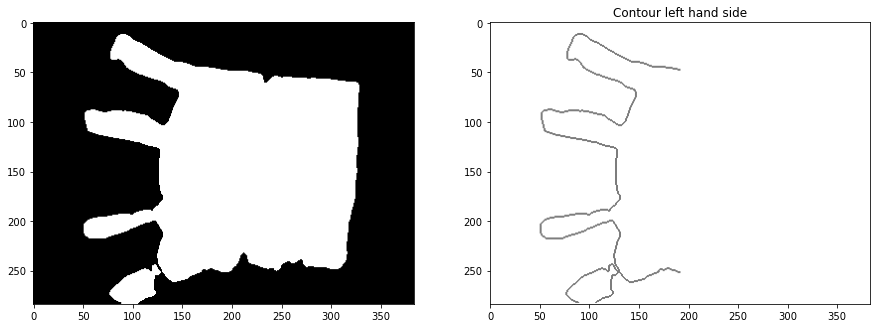

In [12]:
image= modified_img

def get_contour_left_hand_side(image):
    # the countour if a point which has at least different neighbour
    
    lines = image.shape[0]
    columns = image.shape[1]

    countour_points = []

    for i in range(1, lines-1):
        for j in range(1, columns // 2): # the boundaries should be in the first half of the image
            if image[i][j] != image[i][j + 1] or image[i][j] != image[i][j - 1] or \
               image[i][j] != image[i - 1][j] or image[i][j] != image[i + 1][j]:
                countour_points.append((i, j))
                
    return countour_points

countour_points = get_contour_left_hand_side(image)

def visualize_contour_points(grayscale_only, countour_points):
    image = cv2.merge([grayscale_only, grayscale_only, grayscale_only])
    fig, (ax1, ax2) = plt.subplots(1,2,figsize=(15,8))
    ax1.imshow(image)
    
    lines = image.shape[0]
    columns = image.shape[1]
    
    for i in range(lines):
        for j in range(columns):
            if list(set(image[i][j]))[0] == 0:
                image[i][j] = [255, 255, 255]
    
    for coords in countour_points:
        image[coords[0]][coords[1]] = [125, 125, 125] 
    
    ax2.imshow(image)
    ax2.set_title("Contour left hand side")
    plt.show()
    
visualize_contour_points(image, countour_points)

#### Identifying fingers extreme points

In [13]:
def get_coordinates_zones_between_fingers(image):
    lines = image.shape[0]
    columns = image.shape[1]
    
    # between fingers there should be  at least 3 zones with black and 4 zones with white
    # if on a column we have smth like this it means the zones between fingers are started
    
    for col in range(columns // 2):
        fingers_detected_coords = []
        black_zones_detected_coords = []
        for line in range(lines - 1):
            if image[line][col] == 0 and black_zones_detected_coords == [] and fingers_detected_coords == []:
                black_zones_detected_coords.append((line, col))
            elif image[line][col] == 255 and black_zones_detected_coords == [] and fingers_detected_coords == []:
                fingers_detected_coords.append((line, col))
            elif image[line][col] == 0 and image[line + 1][col] == 255:
                black_zones_detected_coords.append((line, col))
            elif image[line][col] == 255 and image[line + 1][col] == 0:
                fingers_detected_coords.append((line, col))
        if len(fingers_detected_coords) == 4:
            break
            
    return fingers_detected_coords

fingers_detected_coords = get_coordinates_zones_between_fingers(image)
fingers_detected_coords

[(36, 78), (115, 78), (215, 78), (275, 78)]

In [14]:
def get_complete_boundaries_between_fingers(image):
    fingers_detected_coords = get_coordinates_zones_between_fingers(image)
    contour_points = get_contour_left_hand_side(image)
    
    lower_bound_x_boundary12 = fingers_detected_coords[0][0]
    upper_bound_x_boundary12 = fingers_detected_coords[1][0]

    lower_bound_x_boundary34 = fingers_detected_coords[2][0]
    upper_bound_x_boundary34 = fingers_detected_coords[3][0]
    
    boundary12_coordinates_set = []
    boundary34_coordinates_set = []
    
    for coordinates in contour_points:
        if coordinates[0] > lower_bound_x_boundary12 and coordinates[0] < upper_bound_x_boundary12:
            boundary12_coordinates_set.append(coordinates)
        elif coordinates[0] > lower_bound_x_boundary34 and coordinates[0] < upper_bound_x_boundary34:
            boundary34_coordinates_set.append(coordinates)

    return boundary12_coordinates_set, boundary34_coordinates_set

boundary12_coordinates_set, boundary34_coordinates_set = get_complete_boundaries_between_fingers(image)

print('boundary12_coordinates_set = ', boundary12_coordinates_set[:10], "etc.")
print('boundary34_coordinates_set = ', boundary34_coordinates_set[:10], "etc.")

boundary12_coordinates_set =  [(37, 78), (37, 79), (37, 80), (37, 81), (37, 82), (37, 83), (37, 84), (37, 85), (37, 86), (37, 87)] etc.
boundary34_coordinates_set =  [(216, 53), (216, 54), (216, 55), (216, 74), (216, 75), (216, 76), (216, 77), (216, 78), (216, 130), (216, 131)] etc.


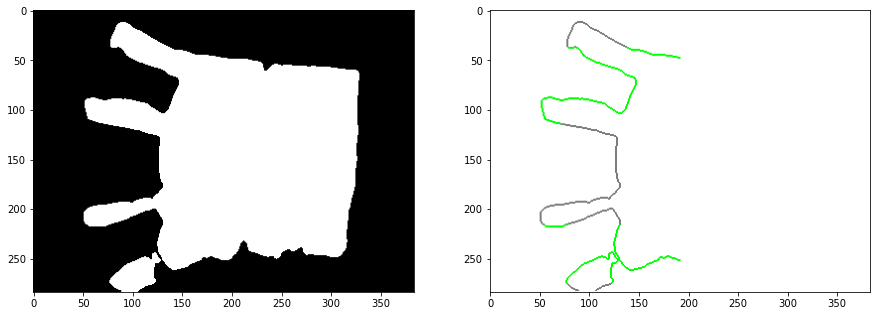

In [15]:
def visualize_complete_boundaries(grayscale_only, boundary12_coordinates_set, boundary34_coordinates_set):
    image = cv2.merge([grayscale_only, grayscale_only, grayscale_only])
    fig, (ax1, ax2) = plt.subplots(1,2,figsize=(15,8))
    ax1.imshow(image)
    
    lines = image.shape[0]
    columns = image.shape[1]
    
    for i in range(lines):
        for j in range(columns):
            if list(set(image[i][j]))[0] == 0:
                image[i][j] = [255, 255, 255]
    
    for coords in countour_points:
        image[coords[0]][coords[1]] = [125, 125, 125] 
        
    for coords in boundary12_coordinates_set:
        image[coords[0]][coords[1]] = [0, 255, 0] 
    
    for coords in boundary34_coordinates_set:
        image[coords[0]][coords[1]] = [0, 255, 0] 
    
    ax2.imshow(image)
    plt.show()
    
visualize_complete_boundaries(image, boundary12_coordinates_set, boundary34_coordinates_set)

#### Identifying the extreme points from the boundaries

In [16]:
def get_starting_points_white(image):
    lines = image.shape[0]
    columns = image.shape[1]

    starting_points_white = []

    for i in range(lines):
        for j in range(columns):
            if image[i][j] == 0:
                continue
            else:
                starting_points_white.append((i, j))
                break

    sorted_coordinates_based_on_line_and_after_column = sorted(sorted(starting_points_white, key=lambda x: x[0]), 
                                                key=lambda x: x[1], reverse=True)
    return sorted_coordinates_based_on_line_and_after_column

In [17]:
def get_extreme_boundaries_of_the_gaps_between_fingers_12_34(image):
    sorted_extreme_point_based_on_line_and_after_column = get_starting_points_white(image)
    
    lower_bound_x_boundary12 = 40
    upper_bound_x_boundary12 = 130

    lower_bound_x_boundary34 = 200
    upper_bound_x_boundary34 = 270

    boundary12_extreme_point = None
    boundary34_extreme_point = None

    for coordinates in sorted_extreme_point_based_on_line_and_after_column:
        if coordinates[0] > lower_bound_x_boundary12 and coordinates[0] < upper_bound_x_boundary12:
            boundary12_extreme_point = coordinates
            break

    for coordinates in sorted_extreme_point_based_on_line_and_after_column:
        if coordinates[0] > lower_bound_x_boundary34 and coordinates[0] < upper_bound_x_boundary34:
            boundary34_extreme_point = coordinates
            break

    return boundary12_extreme_point, boundary34_extreme_point


boundary12_extreme_point, boundary34_extreme_point = get_extreme_boundaries_of_the_gaps_between_fingers_12_34(image)

print('boundary12_extreme_point = ', boundary12_extreme_point)
print('boundary34_extreme_point = ', boundary34_extreme_point)

boundary12_extreme_point =  (70, 147)
boundary34_extreme_point =  (218, 130)


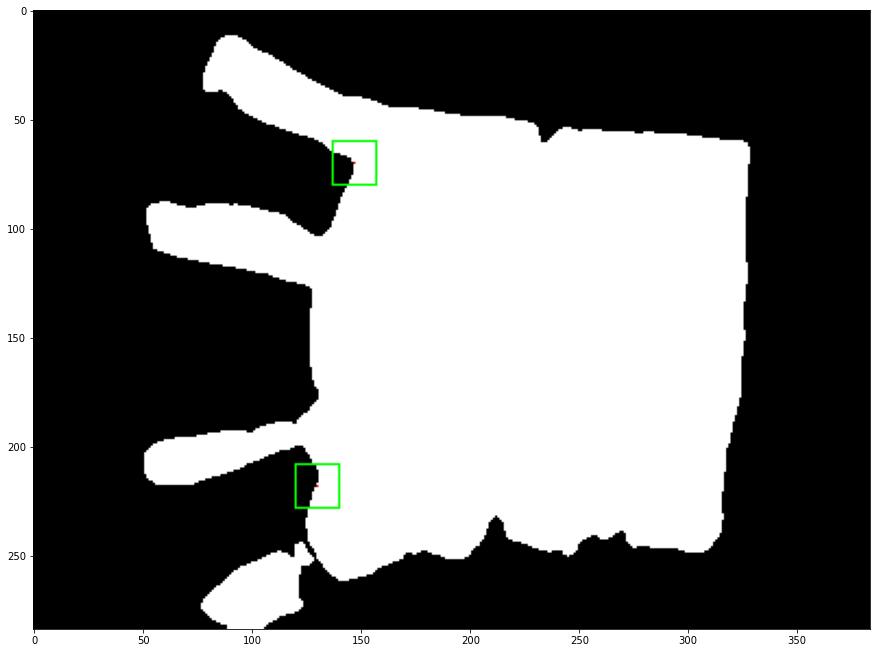

In [18]:
def visualize_chosen_boundaries(grayscale_only, boundary12_extreme_point, boundary34_extreme_point):
    image = cv2.merge([grayscale_only, grayscale_only, grayscale_only])
    image[boundary12_extreme_point[0]][boundary12_extreme_point[1]] = [255, 0, 0] 
    image[boundary34_extreme_point[0]][boundary34_extreme_point[1]] = [255, 0, 0] 
    
    cv2.rectangle(image, (boundary12_extreme_point[1]-10, boundary12_extreme_point[0]-10), 
                         (boundary12_extreme_point[1]+10, boundary12_extreme_point[0]+10), (0, 255, 0), 1) 
    cv2.rectangle(image, (boundary34_extreme_point[1]-10, boundary34_extreme_point[0]-10), 
                         (boundary34_extreme_point[1]+10, boundary34_extreme_point[0]+10), (0, 255, 0), 1)
    fig = plt.figure(figsize=(15,15))
    plt.imshow(image)
    plt.show()

visualize_chosen_boundaries(image, boundary12_extreme_point, boundary34_extreme_point) 

In [19]:
slope = (boundary34_extreme_point[1] - boundary12_extreme_point[1])/ \
        (boundary34_extreme_point[0] - boundary12_extreme_point[0])
slope

-0.11486486486486487

### Detecting the tangent for the boundaries between fingers

boundary12_extreme_point =  (70, 147)
boundary34_extreme_point =  (218, 130)
The equation for the tangent is going to be: y = -0.11486486486486487 * x + 155.04054054054055


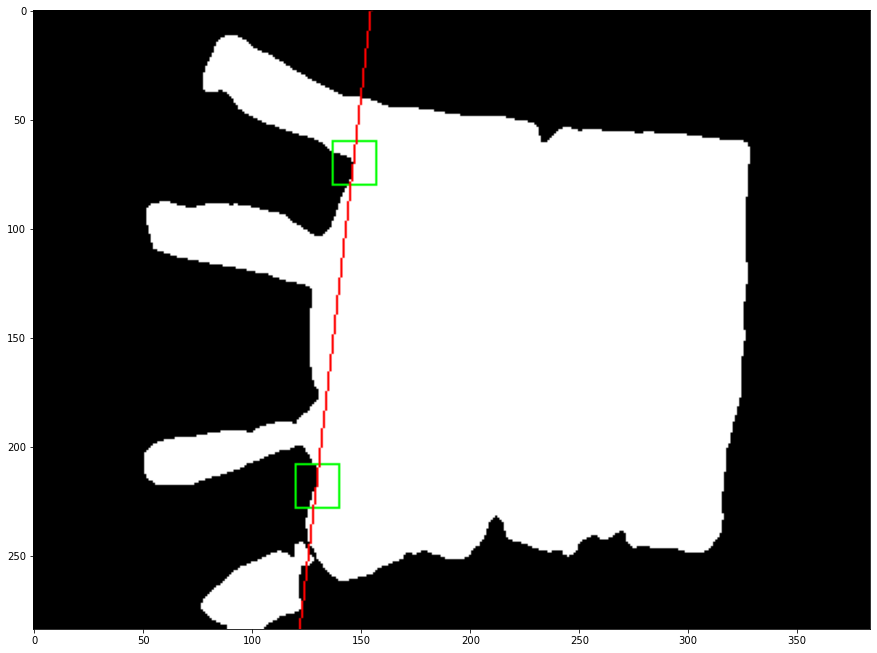

In [20]:
def slope_intercept(x1, y1, x2, y2):
    a = (y2 - y1) / (x2 - x1)
    b = y1 - a * x1     
    return a,b

def visualize_tangent(grayscale_only, boundary12_extreme_point, boundary34_extreme_point):
    image = cv2.merge([grayscale_only, grayscale_only, grayscale_only])
    image[boundary12_extreme_point[0]][boundary12_extreme_point[1]] = [255, 0, 0] 
    image[boundary34_extreme_point[0]][boundary34_extreme_point[1]] = [255, 0, 0] 
    
    cv2.rectangle(image, (boundary12_extreme_point[1]-10, boundary12_extreme_point[0]-10), 
                         (boundary12_extreme_point[1]+10, boundary12_extreme_point[0]+10), (0, 255, 0), 1) 
    cv2.rectangle(image, (boundary34_extreme_point[1]-10, boundary34_extreme_point[0]-10), 
                         (boundary34_extreme_point[1]+10, boundary34_extreme_point[0]+10), (0, 255, 0), 1)
    
    slope, intercept = slope_intercept(boundary34_extreme_point[0], boundary34_extreme_point[1],
                                      boundary12_extreme_point[0], boundary12_extreme_point[1])
    print('boundary12_extreme_point = ', boundary12_extreme_point)
    print('boundary34_extreme_point = ', boundary34_extreme_point)
    print("The equation for the tangent is going to be: y = " + str(slope) + " * x + " + str(intercept))
    
    for line in range(image.shape[0]):
        image[line][int(line * slope + intercept)] = [255, 0, 0] 
    
    fig = plt.figure(figsize=(15,15))
    plt.imshow(image)
    plt.show()
    
visualize_tangent(image, boundary12_extreme_point, boundary34_extreme_point)

#### Verification

Let's take randomly a point from the boundary between fingers and see if the condition is respected.

In [21]:
point1 = (37, 78)
point2 = (216, 53)

In [22]:
slope = -0.11486486486486487
intercept = 155.04054054054055

78 <= slope * 37 + intercept

True

In [23]:
53 <= slope * 216 + intercept

True

### Detecting the new coordinates system

In [24]:
def get_middle_x_y_tangent(boundary12_extreme_point, boundary34_extreme_point):
    middle_between_extreme_points_x = (boundary34_extreme_point[0] - boundary12_extreme_point[0]) // 2 + boundary12_extreme_point[0]
    
    middle_between_extreme_points_y = abs(boundary12_extreme_point[1] - boundary34_extreme_point[1]) // 2 + \
        min(boundary34_extreme_point[1], boundary12_extreme_point[1])
    return middle_between_extreme_points_x, middle_between_extreme_points_y

#### Getting the perpendicular on tangent: m1 * m2 = -1

boundary12_extreme_point =  (70, 147)
boundary34_extreme_point =  (218, 130)
middle tangent coords =  144 138


The equation for the tangent is going to be: y = -0.11486486486486487 * x + 155.04054054054055
The equation for the perpendicular to tangent is going to be: y = 8.705882352941176 * x + -1115.6470588235293


The coordinates for the center of the square are =  154 228
((70, 157), (218, 140), (89, 317), (237, 300))


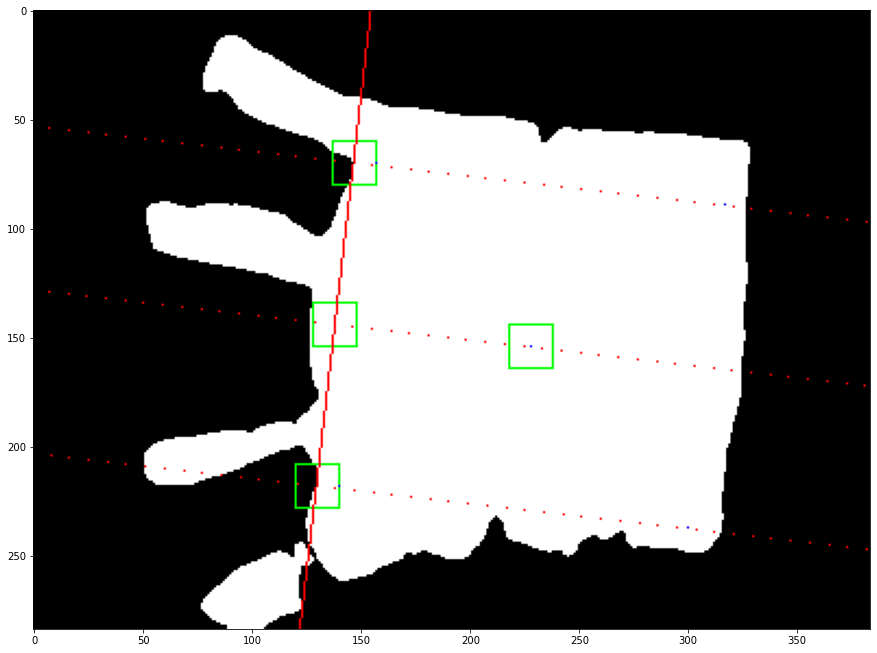

In [25]:
import math 

def sign(x):
    return math.copysign(1, x)

def get_middle_of_the_square(middle_tangent, slope, intercept):
    radius = 80
    border = 10
    center_y = middle_tangent[1] + border + radius
    # y = slope * x + intercept => x = (y - intercept) / slope  
    center_x = int((center_y - intercept) // slope)
    return center_x, center_y

def get_square_points_coords(x12, x34, slope_perpendicular, intercept_12, intercept_34):
    border = 10
    radius = 80
   
    first = (x12[0], x12[1] + border)
    second = (x34[0], x34[1] + border)
    
    third_y = x12[1] + border + 2 * radius  
    third_x = int((third_y - intercept_12) // slope_perpendicular)
    third = (third_x, third_y)
    
    forth_y = x34[1] + border + 2 * radius  
    forth_x = int((forth_y - intercept_34) // slope_perpendicular)
    forth = (forth_x, forth_y)
    return first, second, third, forth
    
def reverse_xy(coords):
    return coords[1], coords[0]


def rotate_image(original_img, angle):
    rows, cols = original_img.shape[:2]
    transformation_matrix = cv2.getRotationMatrix2D((cols / 2, rows / 2), angle, 1)
    rotated = cv2.warpAffine(original_img, transformation_matrix, (cols, rows))
    return rotated
    

def visualize_tangent_and_perpendicular_to_tangent(grayscale_only, boundary12_extreme_point, boundary34_extreme_point):
    image = cv2.merge([grayscale_only, grayscale_only, grayscale_only])
    image[boundary12_extreme_point[0]][boundary12_extreme_point[1]] = [255, 0, 0] 
    image[boundary34_extreme_point[0]][boundary34_extreme_point[1]] = [255, 0, 0] 
    middle_between_extreme_points_x, middle_between_extreme_points_y = get_middle_x_y_tangent(boundary12_extreme_point, boundary34_extreme_point)
    image[middle_between_extreme_points_x][middle_between_extreme_points_y] = [0, 0, 255]
    
    cv2.rectangle(image, (boundary12_extreme_point[1]-10, boundary12_extreme_point[0]-10), 
                         (boundary12_extreme_point[1]+10, boundary12_extreme_point[0]+10), (0, 255, 0), 1) 
    cv2.rectangle(image, (boundary34_extreme_point[1]-10, boundary34_extreme_point[0]-10), 
                         (boundary34_extreme_point[1]+10, boundary34_extreme_point[0]+10), (0, 255, 0), 1)
    cv2.rectangle(image, (middle_between_extreme_points_y-10, middle_between_extreme_points_x-10), 
                         (middle_between_extreme_points_y+10, middle_between_extreme_points_x+10), (0, 255, 0), 1)
    
    slope, intercept = slope_intercept(boundary34_extreme_point[0], boundary34_extreme_point[1],
                                       boundary12_extreme_point[0], boundary12_extreme_point[1])
    
    slope_perpendicular = (-1) / slope
    intercept_perpendicular = middle_between_extreme_points_y - slope_perpendicular * middle_between_extreme_points_x 
    print('boundary12_extreme_point = ', boundary12_extreme_point)
    print('boundary34_extreme_point = ', boundary34_extreme_point)
    print('middle tangent coords = ', middle_between_extreme_points_x, middle_between_extreme_points_y) 
    print("\n\nThe equation for the tangent is going to be: y = " + str(slope) + " * x + " + str(intercept))
    print("The equation for the perpendicular to tangent is going to be: y = " + str(slope_perpendicular) + 
          " * x + " + str(intercept_perpendicular))
    
    for line in range(image.shape[0]):
        image[line][int(line * slope + intercept)] = [255, 0, 0] 
    
    for line in range(image.shape[0]):
        y = int(line * slope_perpendicular + intercept_perpendicular)
        if y > 0  and y < image.shape[1]:
            image[line][y] = [255, 0, 0] 
            
    intercept_x12 = boundary12_extreme_point[1] - slope_perpendicular * boundary12_extreme_point[0] 
    for line in range(image.shape[0]):
        y = int(line * slope_perpendicular + intercept_x12)
        if y > 0  and y < image.shape[1]:
            image[line][y] = [255, 0, 0] 
            
    intercept_x34 = boundary34_extreme_point[1] - slope_perpendicular * boundary34_extreme_point[0]
    for line in range(image.shape[0]):
        y = int(line * slope_perpendicular + intercept_x34)
        if y > 0  and y < image.shape[1]:
            image[line][y] = [255, 0, 0] 
            
    middle_tangent = (middle_between_extreme_points_x, middle_between_extreme_points_y)
    center_x, center_y = get_middle_of_the_square(middle_tangent, slope_perpendicular, intercept_perpendicular)
    
    print("\n\nThe coordinates for the center of the square are = ", center_x, center_y)
    image[center_x][center_y] = [0, 0, 255]
    
    cv2.rectangle(image, (center_y-10, center_x-10), 
                         (center_y+10, center_x+10), (0, 255, 0), 1)
    
    square_coords = get_square_points_coords(boundary12_extreme_point, boundary34_extreme_point, 
                                             slope_perpendicular, intercept_x12, intercept_x34)
    print(square_coords)
    for coord in square_coords:
        image[coord[0]][coord[1]] = [0, 0, 255] 
    
    fig = plt.figure(figsize=(15,15))
    plt.imshow(image)
    plt.show()
    
    
visualize_tangent_and_perpendicular_to_tangent(image, boundary12_extreme_point, boundary34_extreme_point)

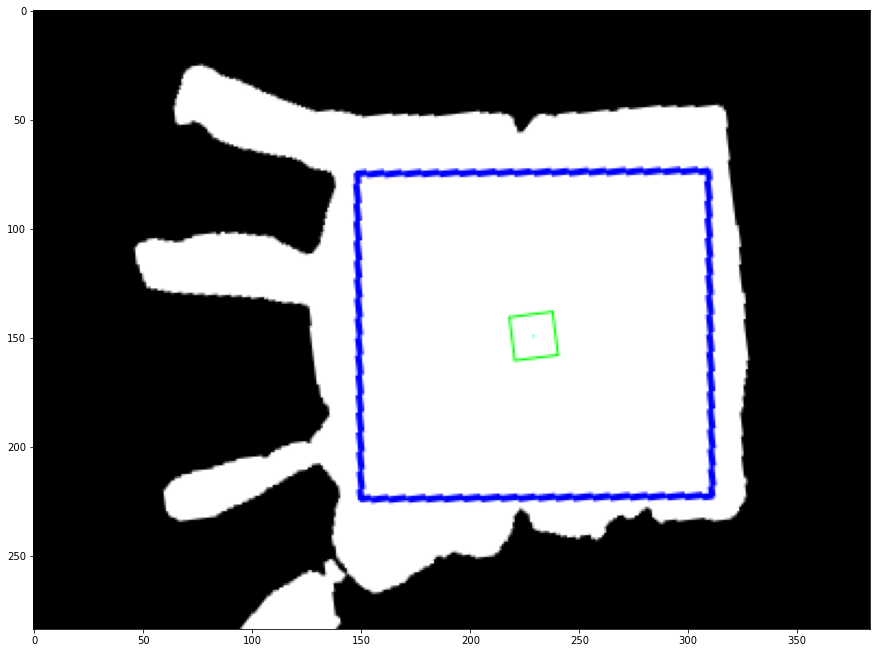

In [26]:
def visualize_tangent_and_perpendicular_to_tangent(grayscale_only, boundary12_extreme_point, 
                                                   boundary34_extreme_point, show_result=True):
    image = cv2.merge([grayscale_only, grayscale_only, grayscale_only])
    
    middle_between_extreme_points_x, middle_between_extreme_points_y = get_middle_x_y_tangent(boundary12_extreme_point, boundary34_extreme_point)
    
    slope, intercept = slope_intercept(boundary34_extreme_point[0], boundary34_extreme_point[1],
                                       boundary12_extreme_point[0], boundary12_extreme_point[1])
    
    slope_perpendicular = (-1) / slope
    intercept_perpendicular = middle_between_extreme_points_y - slope_perpendicular * middle_between_extreme_points_x 
            
    middle_tangent = (middle_between_extreme_points_x, middle_between_extreme_points_y)
    center_x, center_y = get_middle_of_the_square(middle_tangent, slope_perpendicular, intercept_perpendicular)
    
    image[center_x][center_y] = [0, 255, 255]
    
    cv2.rectangle(image, (center_y-10, center_x-10), 
                         (center_y+10, center_x+10), (0, 255, 0), 1)
    
    intercept_x12 = boundary12_extreme_point[1] - slope_perpendicular * boundary12_extreme_point[0] 
    intercept_x34 = boundary34_extreme_point[1] - slope_perpendicular * boundary34_extreme_point[0]
    
    square_coords = get_square_points_coords(boundary12_extreme_point, boundary34_extreme_point, 
                                             slope_perpendicular, intercept_x12, intercept_x34)
    for coord in square_coords:
        image[coord[0]][coord[1]] = [0, 0, 255] 
    
    cv2.line(image, reverse_xy(square_coords[0]), reverse_xy(square_coords[1]), [0, 0, 255], 2)
    cv2.line(image, reverse_xy(square_coords[1]), reverse_xy(square_coords[3]), [0, 0, 255], 2)
    cv2.line(image, reverse_xy(square_coords[3]), reverse_xy(square_coords[2]), [0, 0, 255], 2)
    cv2.line(image, reverse_xy(square_coords[2]), reverse_xy(square_coords[0]), [0, 0, 255], 2)
    
    if show_result == True:
        image = rotate_image(image, 5*np.arctan(slope_perpendicular))
        fig = plt.figure(figsize=(15,15))
        plt.imshow(image)
        plt.show()
    
    return image
    
img_mod = visualize_tangent_and_perpendicular_to_tangent(image, boundary12_extreme_point, boundary34_extreme_point)

### Get all coordinates inside rectagle

In [27]:
def check_current_has_value_rgb(pixel, rgb):
    correct = True
    for i in range(3):
        if pixel[i] != rgb[i]:
            correct = False
    return correct

def get_coords_first_last_rotated_rectangle(rotated_image):
    for column in range(rotated_image.shape[1]):
        found = False
        for line in range(rotated_image.shape[0]):
            if check_current_has_value_rgb(rotated_image[line][column], [0,0,255]):
                found = True
                break
        if found:
            break
    first_point = (line, column)
    
    for column in range(rotated_image.shape[1]-1, 0, -1):
        found = False
        for line in range(rotated_image.shape[0]-1, 0, -1):
            if check_current_has_value_rgb(rotated_image[line][column], [0,0,255]):
                found = True
                break
        if found:
            break
    last_point = (line, column)
    return first_point, last_point

coords = get_coords_first_last_rotated_rectangle(img_mod)
print(len(coords))

2


### Gather everything in a preprocessing function

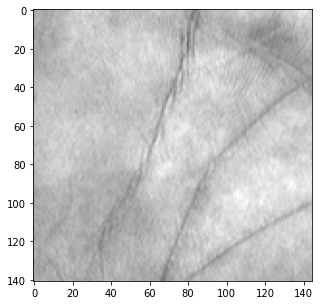

In [35]:
def apply_preprocessing_palmprint(filename, show_result=True):
    original_img = cv2.imread(filename, 0)
    modified_img = gaussian_blur(original_img, filter_size)
    modified_img = thresholding_to_binary(modified_img)
    image = modified_img
    boundary12_extreme_point, boundary34_extreme_point = get_extreme_boundaries_of_the_gaps_between_fingers_12_34(image)
    
    visualize_tangent_and_perpendicular_to_tangent(image, boundary12_extreme_point, 
                                                   boundary34_extreme_point, show_result)
    first, last = get_coords_first_last_rotated_rectangle(img_mod)
    original_img = cv2.merge([original_img, original_img, original_img])
    cropped = original_img[first[0]:last[0], first[1]:last[1]-20]
    
    return cropped
    
processed = apply_preprocessing_palmprint('./imagini/PolyU_386_F_08.bmp', False)

fig = plt.figure(figsize=(5,5))
plt.imshow(processed)
plt.show()

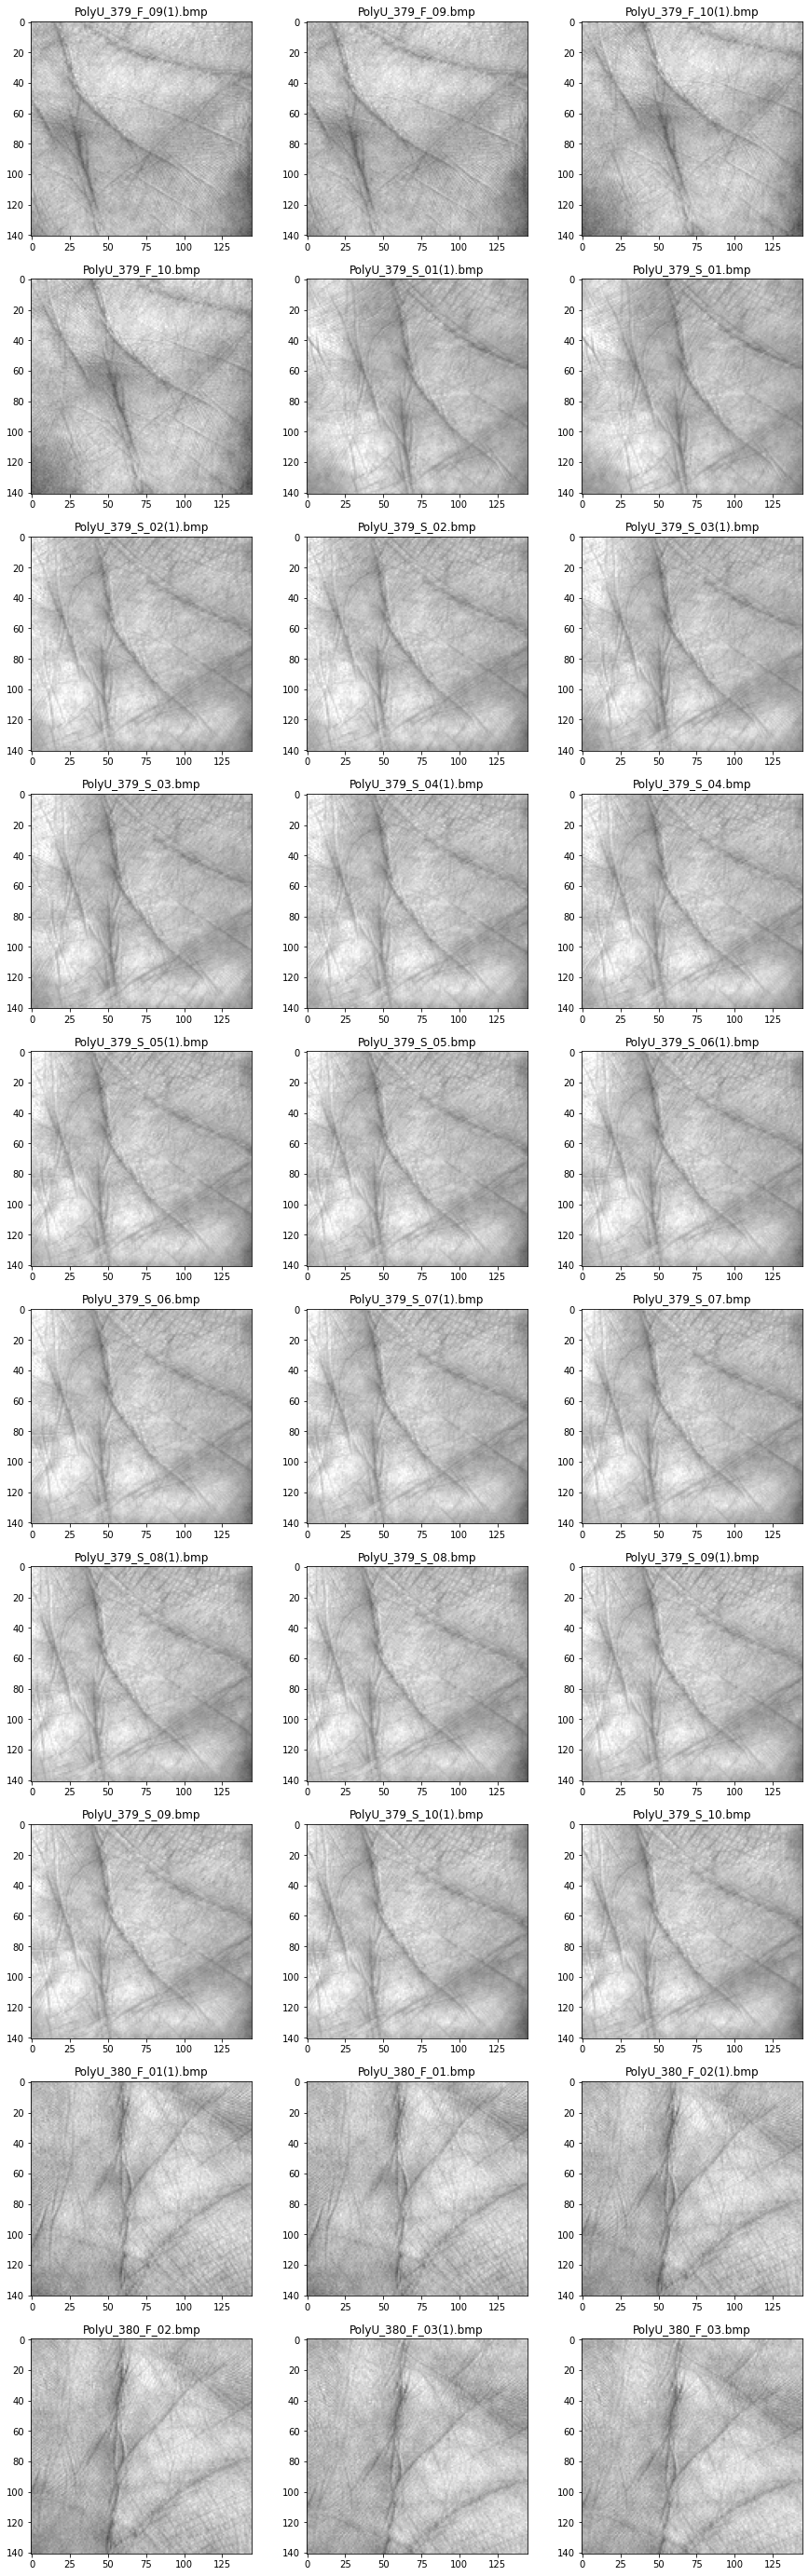

In [44]:
fig, ax = plt.subplots(30,1,figsize=(15,50))

index_plot = 1
for filename in sorted(os.listdir('./imagini/'))[:30]:
    plt.subplot(10, 3, index_plot)
    plt.imshow(apply_preprocessing_palmprint('./imagini/' + filename, False))
    plt.title(filename)
    index_plot += 1

### Export results after processing

In [46]:
for filename in tqdm.tqdm(sorted(os.listdir('./imagini/'))):
    try:
        processed = apply_preprocessing_palmprint('./imagini/' + filename, False)
    except:
        pass
    cv2.imwrite('./processed/' + filename, processed) 

100%|██████████| 300/300 [02:14<00:00,  2.22it/s]


## Feature Extraction and Coding

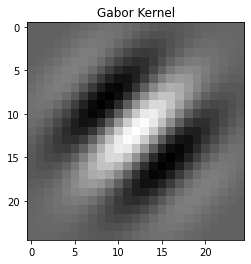

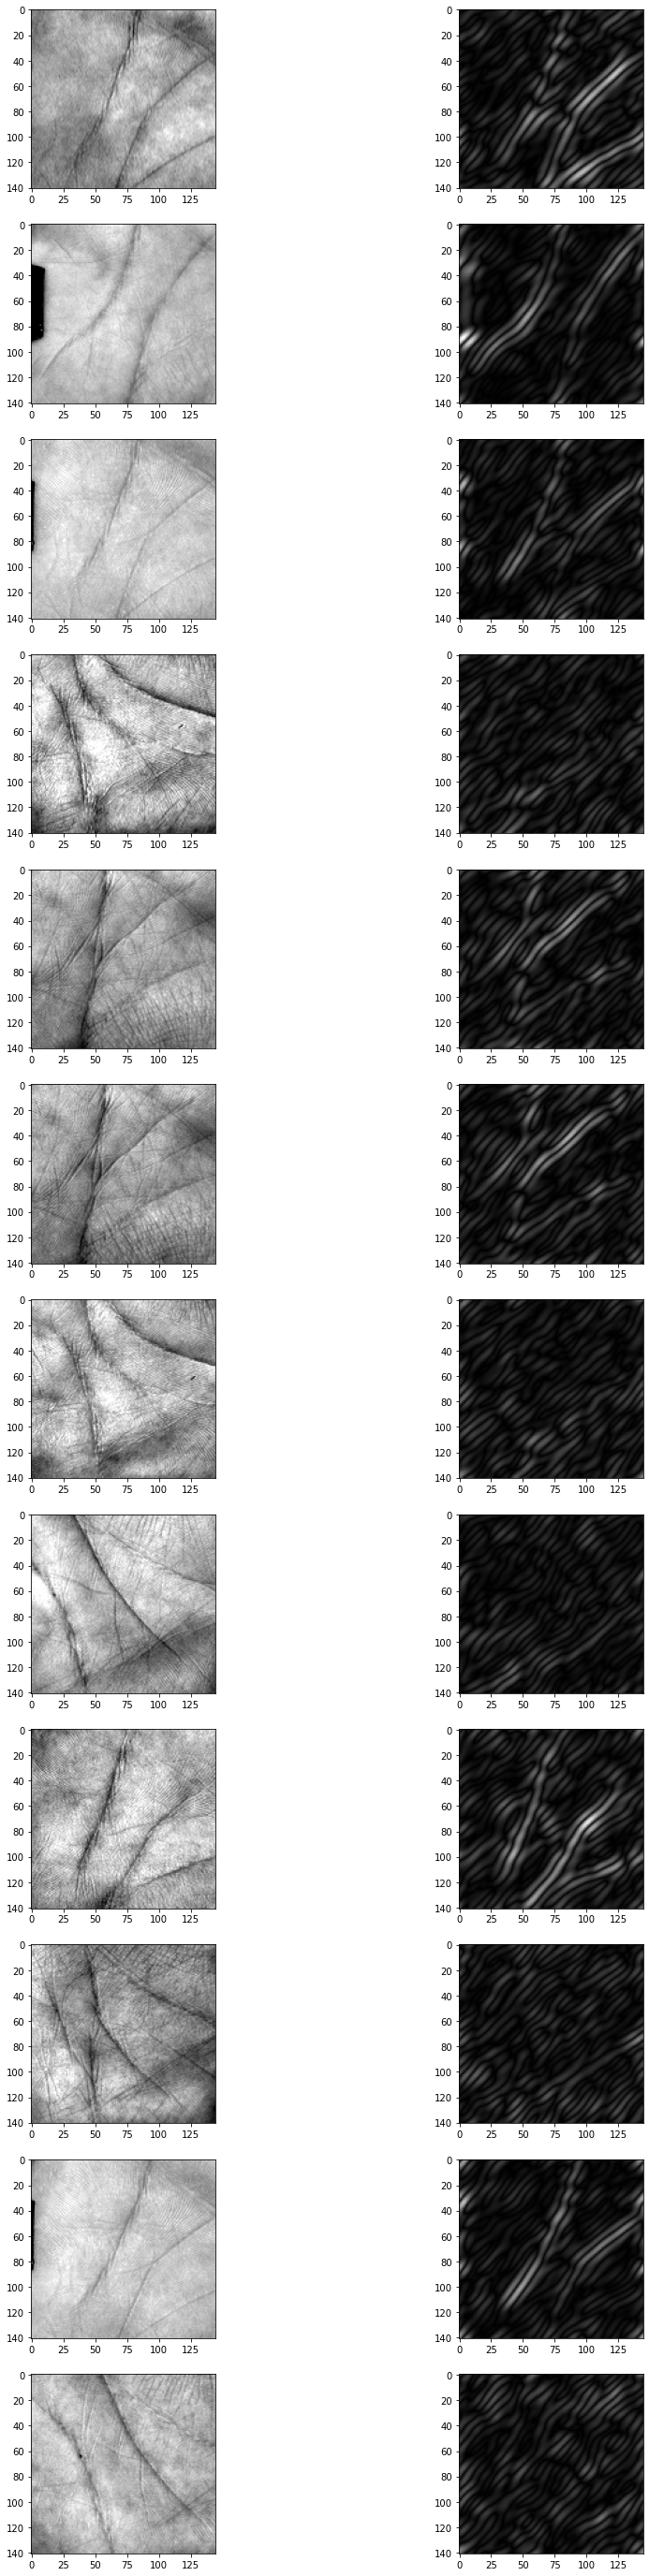

In [95]:
from skimage.filters import gabor_kernel
from skimage.util import img_as_float
from scipy import ndimage as nd

THETA = np.pi/4
SIGMA = 5.6179 # standard deviation of the Gaussian envelope
FREQUENCY = 0.0916

filename = './processed/PolyU_386_F_08.bmp'
    
kernel = np.real(gabor_kernel(FREQUENCY, theta=THETA, sigma_x=SIGMA, sigma_y=SIGMA))

def compute_feats(image, kernel):
    feats = np.zeros((1, 2), dtype=np.double)
    filtered = nd.convolve(image, kernel, mode='wrap')
    feats[0, 0] = filtered.mean()
    feats[0, 1] = filtered.var()
    return feats


def match(feats, ref_feats):
    min_error = np.inf
    min_i = None
    for i in range(ref_feats.shape[0]):
        error = np.sum((feats - ref_feats[i, :])**2)
        if error < min_error:
            min_error = error
            min_i = i
    return min_i

def power(image, kernel):
    # Normalize images for better comparison.
    image = (image - image.mean()) / image.std()
    return np.sqrt(nd.convolve(image, np.real(kernel), mode='wrap')**2 +
                   nd.convolve(image, np.imag(kernel), mode='wrap')**2)
                       

image_names = sorted(os.listdir('./processed/'))[:12]
images = [cv2.imread('./processed/' + filename, 0) for filename in os.listdir('./processed/')][:12]
powers = [power(img, kernel) for img in images]

plt.imshow(np.real(kernel), interpolation='nearest')
plt.title('Gabor Kernel')
plt.show()


fig, ax = plt.subplots(24,1,figsize=(15,50))
index_plot = 1

for i in range(len(image_names)):
    image_name = image_names[i]
    image = images[i]

    plt.subplot(12,2,index_plot)
    plt.imshow(np.uint8(image))

    plt.subplot(12,2,index_plot + 1)
    
    vmin = np.min(powers)
    vmax = np.max(powers)
    plt.imshow(powers[i], vmin=vmin, vmax=vmax)
    index_plot += 2

plt.show()